# Submission 3 &ndash; Final Submission

## Instructions

- Fill out the *Basic Information* and the *Results* sections.
- Make sure that this `.ipynb` file displays correctly in the GitHub file preview, including any visual output.
- If you find that any output does not display correctly, include a static screenshot as an image. For interactive outputs, add a link to a short screencast located in your repository.
- Push all required files before the deadline.

---
## Basic Information

**Team Name:** TODO

**Team Members:**
- TODO
- TODO
- TODO
- TODO

**Dataset Description:**  
(max. 75 words; this serves just as a reminder)

< Your dataset description goes here >

---

## Code

Here you may place any code that is not an immediate part of your submission. Only the content of the *Results* sections will be graded for this submission.

In [36]:
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import Output, HBox, VBox, HTML
from IPython.display import clear_output, display, Image
import ipywidgets as widgets
from ipywidgets import Layout
import pandas as pd
import numpy as np
import math

owid_data: pd.DataFrame = pd.read_csv('owid-energy-data.csv')

def prepare_data(data: pd.DataFrame, year: int) -> pd.DataFrame:
    # '*_share_energy' is being adjusted by its efficiency, so its not useful for our plot
    # columns = ['country', 'year', 'iso_code'] + [x for x in owid_data.columns if 'share' in x and 'elec' in x]
    columns = ['country', 'year', 'iso_code'] + ['solar_share_elec', 'wind_share_elec', 'oil_share_elec', 'nuclear_share_elec', 'hydro_share_elec', 'gas_share_elec', 'coal_share_elec', 'biofuel_share_elec']

    data = data[columns]

    # Drop all aggregates
    data = data[data['iso_code'].notna()]

    # Filter by year
    data = data[data['year'] == year]

    # data = data[(1980 <= data['year']) & (data['year'] <= 2020)]

    data.iloc[:, 3:] = data.iloc[:, 3:].fillna(0)
    
    return data

energy_colors = {
    'solar_share_elec': '#f0cc2e',
    'wind_share_elec': '#bc5090',
    'oil_share_elec': '#a9522e',
    'nuclear_share_elec': '#9dbd3d',
    'hydro_share_elec': '#82a0e5',
    'gas_share_elec': '#8f66ff',
    'coal_share_elec': '#545568',
    'biofuel_share_elec': '#51a16a'
}

energy_columns = {
    'Solar': 'solar_share_elec',
    'Wind': 'wind_share_elec',
    'Oil': 'oil_share_elec',
    'Nuclear': 'nuclear_share_elec',
    'Hydro': 'hydro_share_elec',
    'Gas': 'gas_share_elec',
    'Coal': 'coal_share_elec',
    'Biofuel': 'biofuel_share_elec'
}

selected_country = None

year_slider = widgets.IntSlider(
    min=2000,
    max=2020,
    step=1,
    description='Year:     ',
)

energy_dropdown = widgets.Dropdown(
    options=list(energy_columns.keys()),
    description='Energy Source:',
    value=None
)

fig_widget = None
camera_state = None
click_times = []

def plot_map(owid_data: pd.DataFrame, year: int, energy_source: str = 'Solar'):
    global fig_widget, camera_state
    data = prepare_data(owid_data, year)
    
    energy_column = energy_columns.get(energy_source)
    selected_color = energy_colors.get(energy_column)

    # print(camera_state)
    if 'fig_widget' in globals() and fig_widget is not None and fig_widget.data and not camera_state:
        camera_state = fig_widget.layout.geo['projection']
    # print(camera_state)
    
    if energy_source is not None:
        fig = px.choropleth(
            data, 
            locations='iso_code', 
            color=energy_column, 
            title=f'{energy_source} power share by country ({year})', 
            width=600, 
            height=600, 
            color_continuous_scale=['white', selected_color],
            range_color=[0, data[energy_column].max()],
        )
        
        fig.update_traces(
            customdata=data.apply(lambda row: f"{row['country']}: {row[energy_column]:.2f}%" if row[energy_column] != -1 else "No Data", axis=1),
            hovertemplate='%{customdata}'
        )

        fig.update_layout(
            coloraxis_colorbar=dict(
                orientation='h',
                x=0.5,
                xanchor='center',
                y=-0.2,
                title=f"{energy_source} power share (%)",
                tickvals=[0, data[energy_column].max()],
                ticktext=[f"0%", f"{int(np.ceil(data[energy_column].max()))}%"],
            )
        )
    else:
        fig = px.choropleth(
            None,
            color=energy_column, 
            title=f'Please select the energy source first', 
            width=600, 
            height=600, 
        )

    
    fig.update_geos(
        projection_type="orthographic",
        lakecolor="#86d7ff",
        showocean=True, 
        oceancolor="#86d7ff",
        landcolor="white", 
        showcountries=True, 
        showland=True,
    )
    
    fig_widget = go.FigureWidget(fig)
    fig_bar = go.FigureWidget(
        go.Bar(
            x=[],
            y=[],
            marker=dict(color=["#FFFFFF"])
        )
    )
    # print(selected_country)
    if selected_country is not None:
        for i, layer in enumerate(fig_widget.data):
            if layer.name and layer.name.startswith("Selected:"):
                fig_widget.data = tuple(
                    d for j, d in enumerate(fig_widget.data) if j != i
                )
                break

        country_data = data[data['country'] == selected_country].iloc[0]
        selected_iso = data[data['country'] == selected_country]['iso_code'].values[0]
        fig_widget.add_scattergeo(
            locations=[selected_iso],
            locationmode='ISO-3',
            marker=dict(size=20, color='rgba(0,0,0,0)', line=dict(color='black', width=2)),
            name=f"Selected: {selected_country}",
            showlegend=False,
            hoverinfo='skip'  # Prevent interception of clicks
        )

        shares = [(key, country_data.get(column, 0)) for key, column in energy_columns.items()]
        filtered_shares = [(key, share) for key, share in shares if share > 0]
    
        if filtered_shares:
            filtered_shares.sort(key=lambda x: x[1], reverse=True)
            energy_sources, values = zip(*filtered_shares)
        else:
            energy_sources, values = [], []
        
        fig_bar.data = []
        fig_bar.add_trace(
            go.Bar(
                x=list(energy_sources),
                y=[value if value >=1 else 1 for value in values],
                text=[f"{round(value, 2):.2f}%" if value >= 1 else "<1%" for value in values],
                textposition='outside',
                marker=dict(
                    color=[energy_colors[energy_columns[source]] if source == energy_source else "#D3D3D3" for source in energy_sources],
                    line=dict(
                        color='black',
                        width=0.3
                    )
                ),
                hoverinfo='none',
                showlegend=False,
            )
        )

        fig_bar.update_layout(
            title={
                'text': f"Energy shares for {country_data['country']} ({country_data['year']})",
                'x': 0,
                'xanchor': 'left',
                'y': 0.95,
                'yanchor': 'top',
            },
            xaxis=dict(
                title="Energy Source",
                fixedrange=True,
                showgrid=False,
                visible=True,
            ),
            yaxis=dict(
                title="Share (%)",
                type='linear',
                fixedrange=True,
                showgrid=True,
                visible=True,
                gridcolor='lightgray',
            ),
            plot_bgcolor='white',
            paper_bgcolor='white',
            showlegend=False,
            # margin=dict(l=0, r=0, t=0, b=0),  # Remove margins
        )
    
    else:
        fig_bar.update_layout(
            title={'text':'' if energy_source is None else 'Double click on a country to see its energy mix'},
            xaxis=dict(visible=False),  # Hide x-axis
            yaxis=dict(visible=False),  # Hide y-axis
            plot_bgcolor='white',       # Set background to white
            # margin=dict(l=0, r=0, t=0, b=0),  # Remove margins
        )

    if camera_state:
        fig_widget.layout.geo['projection'] = camera_state

        camera_state = None
    
    bar_output = Output()

    def update_bar_chart(trace, points, selector):
        global selected_country
        if points.point_inds:
            idx = points.point_inds[0]
            country_data = data.iloc[idx]

            # Remove existing scatter geo layer for the previous selection
            if selected_country:
                for i, layer in enumerate(fig_widget.data):
                    if layer.name and layer.name.startswith("Selected:"):
                        fig_widget.data = tuple(
                            d for j, d in enumerate(fig_widget.data) if j != i
                        )
                        break
            # print(selected_country)
            if selected_country == country_data['country']:
                selected_country = None
                with bar_output:
                    bar_output.clear_output(wait=True)
                    fig_bar.data = []
                    fig_bar.update_layout(
                        title={'text':''},
                        xaxis=dict(visible=False),  # Hide x-axis
                        yaxis=dict(visible=False),  # Hide y-axis
                        plot_bgcolor='white',       # Set background to white
                        # margin=dict(l=0, r=0, t=0, b=0),  # Remove margins
                    )
                    
                    fig_bar.show()
                return
            else:
                selected_country = country_data['country']
                selected_iso = data[data['country'] == selected_country]['iso_code'].values[0]
                fig_widget.add_scattergeo(
                    locations=[selected_iso],
                    locationmode='ISO-3',
                    marker=dict(size=20, color='rgba(0,0,0,0)', line=dict(color='black', width=2)),
                    name=f"Selected: {selected_country}",
                    showlegend=False,
                    hoverinfo='skip'  # Prevent interception of clicks
                )
                # print(selected_country)
                # fig_widget.show()

                
            
            shares = [(key, country_data.get(column, 0)) for key, column in energy_columns.items()]
            filtered_shares = [(key, share) for key, share in shares if share > 0]
    
            if filtered_shares:
                filtered_shares.sort(key=lambda x: x[1], reverse=True)
                energy_sources, values = zip(*filtered_shares)
            else:
                energy_sources, values = [], []
    
            with bar_output:
                bar_output.clear_output(wait=True)
                fig_bar.data = []
                fig_bar.add_trace(
                    go.Bar(
                        x=list(energy_sources),
                        y=[value if value >=1 else 1 for value in values],
                        text=[f"{round(value, 2):.2f}%" if value >= 1 else "<1%" for value in values],
                        textposition='outside',
                        marker=dict(
                            color=[energy_colors[energy_columns[source]] if source == energy_source else "#D3D3D3" for source in energy_sources],
                            line=dict(
                                color='black',
                                width=0.3
                            )
                        ),
                        hoverinfo='none',
                        showlegend=False,
                    )
                )
    
                fig_bar.update_layout(
                    title={
                        'text': f"Energy shares for {country_data['country']} ({country_data['year']})",
                        'x': 0,
                        'xanchor': 'left',
                        'y': 0.95,
                        'yanchor': 'top',
                    },
                    xaxis=dict(
                        title="Energy Source",
                        fixedrange=True,
                        showgrid=False,
                        visible=True,
                    ),
                    yaxis=dict(
                        title="Share (%)",
                        type='linear',
                        fixedrange=True,
                        showgrid=True,
                        visible=True,
                        gridcolor='lightgray',
                    ),
                    plot_bgcolor='white',
                    paper_bgcolor='white',
                    showlegend=False,
                    # margin=dict(l=0, r=0, t=0, b=0),  # Remove margins
                )

                fig_bar.show()

    def handle_double_click(trace, points, selector):
        global click_times, camera_state
        from time import time
    
        # Record the time of the click
        current_time = time()
        click_times.append(current_time)
    
        # Keep only the last two clicks
        if len(click_times) > 2:
            click_times.pop(0)
    
        # Detect double-click
        if len(click_times) == 2 and (click_times[1] - click_times[0]) < 0.25:  # 250 ms threshold
            # Capture the current geo projection state before updating the chart
            # print('double click')
            if fig_widget.layout.geo:
                camera_state = fig_widget.layout.geo['projection']

            update_bar_chart(trace, points, selector)
            
            # # Temporarily change the dropdown value to force a refresh
            # original_value = energy_dropdown.value
            # temp_value = list(energy_dropdown.options)[0] if original_value != list(energy_dropdown.options)[0] else list(energy_dropdown.options)[1]
            
            # # Update the widget to a different value, then back to the original
            # energy_dropdown.value = temp_value
            # energy_dropdown.value = original_value
            # Temporarily change the dropdown value to force a refresh
            original_value = year_slider.value
            temp_value = original_value + 1 if original_value < year_slider.max else original_value - 1
            
            # Update the widget to a different value, then back to the original
            year_slider.value = temp_value
            year_slider.value = original_value

    # def clear_bar(*args):
    #     with bar_output:
    #         bar_output.clear_output(wait=True)
    #         fig_bar.data = []
    #         fig_bar.update_layout(
    #             title={'text':''},
    #             xaxis=dict(visible=False),  # Hide x-axis
    #             yaxis=dict(visible=False),  # Hide y-axis
    #             plot_bgcolor='white',       # Set background to white
    #             # margin=dict(l=0, r=0, t=0, b=0),  # Remove margins
    #         )
            
    #         fig_bar.show()
    # def on_unhover(*args):
        # print('Unhovering!!!!!')
    
    # fig_widget.data[0].on_click(update_bar_chart)
    fig_widget.data[0].on_click(handle_double_click)
    # fig_widget.data[0].on_unhover(on_unhover)

    grid_layout = HBox(
        [fig_widget, fig_bar], 
        layout=Layout(justify_content='space-between', height='100%')
    )
    display(grid_layout)

    return grid_layout

# Uncomment the following to see the visualization B1
    
# interactive_output = widgets.interactive_output(plot_map, {'owid_data': widgets.fixed(owid_data), 'year': year_slider, 'energy_source': energy_dropdown})
# display(VBox([HBox([year_slider, energy_dropdown]), interactive_output]))

---
## Results &ndash; Complex Hypotheses/Tasks

### B.1

Restate your hypothesis/task below.

~~Hypothesis~~ / **Task B.1:** Determine the share of renewable and non-renewable energy sources in the total electricity generation of countries worldwide during certain time interval. 

Place your visualizations below (max. 2). Make sure that everyting displays correctly in the GitHub file preview.

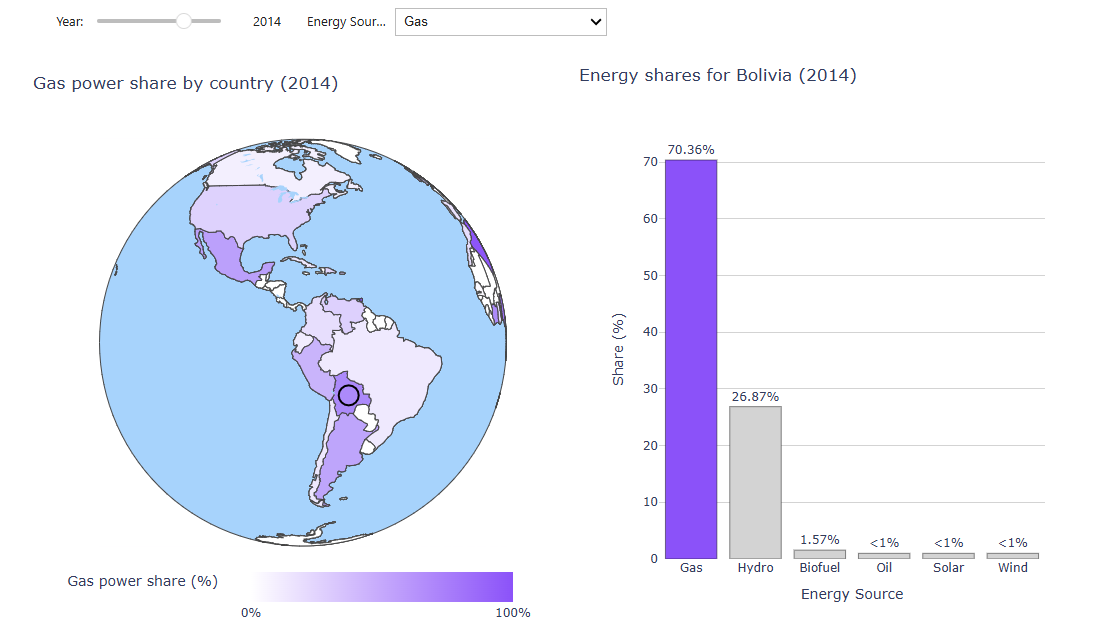

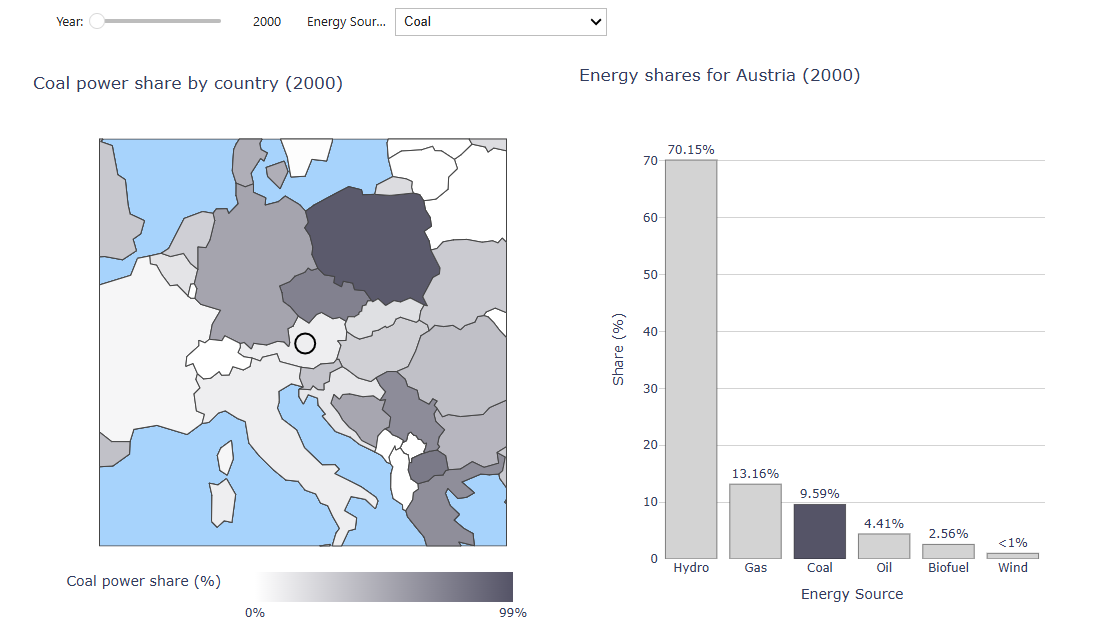

In [41]:
display(Image(filename='B1.1.png'))
display(Image(filename='B1.2.png'))

<b>To see the interactive visualization: [Click](https://github.com/jku-icg-classroom/visualization-lab-project-the-leading-figures/blob/master/project/sub_03_final/B1.mp4) </b>

Describe your visualizations and findings. Be clear which chart(s) you are referring to and relate your findings to the hypothesis/task.
Use no more than 150 words and indicate the word count of your description below.

**Description:** Interactive visualization provides users with information about the share of the selected energy source in the total electricity generation of countries worldwide in a particular year. Color shades of each country encode the share of the selected energy source, the value of which one can derive from the color scale or observe by hovering the mouse on the country.  By pinning the country using the double-click one can see the barplot about the total energy mix or total electricity generation of the pinned country. The values on top of the bars encode the share of energy types that make up the country's electricity generation.

**Word count**: 104

### B.2

Restate your hypothesis/task below.

**Hypthesis/Task B.2:** TODO

Place your visualizations below (max. 2). Make sure that everyting displays correctly in the GitHub file preview.

TODO

Describe your visualizations and findings. Be clear which chart(s) you are referring to and relate your findings to the hypothesis/task. Use no more than 150 words and indicate the word count of your description below.

**Description:** TODO

**Word count**: TODO

---

## Results &ndash; Black-Hat Visualization

Place your black hat visualization below. Make sure that everything displays correctly in the GitHub file preview.

TODO

Describe your black-hat visualization. What was your motivation? How did you achieve the desired effect? Use no more than 150 and indicate the word count of your description below.

**Description:** TODO

**Word count:** TODO